# Three-Period Interrupted Time Series

This notebook demonstrates the three-period interrupted time series design, which extends the standard two-period design to analyze **temporary interventions** with defined start and end times. This is particularly useful for:

- Marketing campaigns with specific start and end dates
- Policy trials or pilot programs
- Clinical treatments with limited duration
- Seasonal interventions

The three-period design enables you to:

1. **Analyze immediate effects** during the intervention period
2. **Measure effect persistence** after the intervention ends
3. **Quantify effect decay** patterns over time

By specifying `treatment_end_time`, the analysis automatically splits the post-intervention period into:

- **Intervention period**: From `treatment_time` to `treatment_end_time` (when treatment is active)
- **Post-intervention period**: After `treatment_end_time` (when treatment has ended)

This allows for separate analysis of effects during and after the intervention, providing insights into both immediate impact and long-term persistence.


## What is the three-period design?

In a standard interrupted time series (two-period design), we compare:

- **Pre-intervention period**: Before treatment starts
- **Post-intervention period**: After treatment starts (assumed permanent)

The three-period design adds a third period by splitting the post-intervention period:

- **Pre-intervention period**: Before treatment starts
- **Intervention period**: When treatment is actively applied (from `treatment_time` to `treatment_end_time`)
- **Post-intervention period**: After treatment ends (from `treatment_end_time` onward)

This design is essential when interventions are temporary, as it allows you to:

- Measure the **immediate effect** during the intervention
- Assess **effect persistence** (how much of the effect remains after the intervention ends)
- Analyze **effect decay** (how quickly effects fade over time)

For more details, see the glossary entries on {term}`intervention period`, {term}`effect persistence`, and {term}`effect decay`.


## Example: Marketing Campaign Analysis

We'll simulate a marketing campaign scenario where:

- A company runs a 12-week promotional campaign
- Sales increase during the campaign (immediate effect)
- Some effect persists after the campaign ends (persistence)
- The effect gradually decays over time (decay pattern)


In [1]:
import arviz as az
import numpy as np
import pandas as pd

import causalpy as cp

c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\pymc_extras\model\marginal\graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

### Simulate data with three periods


In [3]:
# Set up time series
rng = np.random.default_rng(seed)
dates = pd.date_range(start="2023-01-01", end="2024-12-31", freq="W")
n_weeks = len(dates)

# Define intervention periods
treatment_idx = n_weeks // 2  # Mid-point of time series
treatment_end_idx = treatment_idx + 12  # 12-week campaign
treatment_time = dates[treatment_idx]
treatment_end_time = dates[treatment_end_idx]

print(f"Treatment starts: {treatment_time}")
print(f"Treatment ends: {treatment_end_time}")
print(f"Campaign duration: {treatment_end_idx - treatment_idx} weeks")

Treatment starts: 2023-12-31 00:00:00
Treatment ends: 2024-03-24 00:00:00
Campaign duration: 12 weeks


In [9]:
# Simulate baseline sales: trend + seasonality + noise
trend = np.linspace(100, 120, n_weeks)
season = 10 * np.sin(2 * np.pi * np.arange(n_weeks) / 52)  # Annual seasonality
noise = rng.normal(0, 1, n_weeks)
baseline = trend + season + noise

# Add intervention effects
sales = baseline.copy()

# During intervention: +50 units (immediate effect)
sales[treatment_idx:treatment_end_idx] += 50

# Post-intervention: gradual decay from +15 to +5 units (persistence with decay)
post_periods = n_weeks - treatment_end_idx
decay_factor = np.exp(-np.arange(post_periods) / 20)  # Exponential decay
persistent_effect = 15 * decay_factor + 5  # Decay from 15 to 5
sales[treatment_end_idx:] += persistent_effect

# Create DataFrame
df = pd.DataFrame(
    {
        "sales": sales,
        "t": np.arange(n_weeks),
        "month": dates.month,
    },
    index=dates,
)

df.head()

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


,sales,t,month
obs_ind,,,
2023-01-01,99.794562,0,1
2023-01-08,100.447652,1,1
2023-01-15,102.438739,2,1
2023-01-22,104.963280,3,1
2023-01-29,103.689142,4,1


### Visualize the data


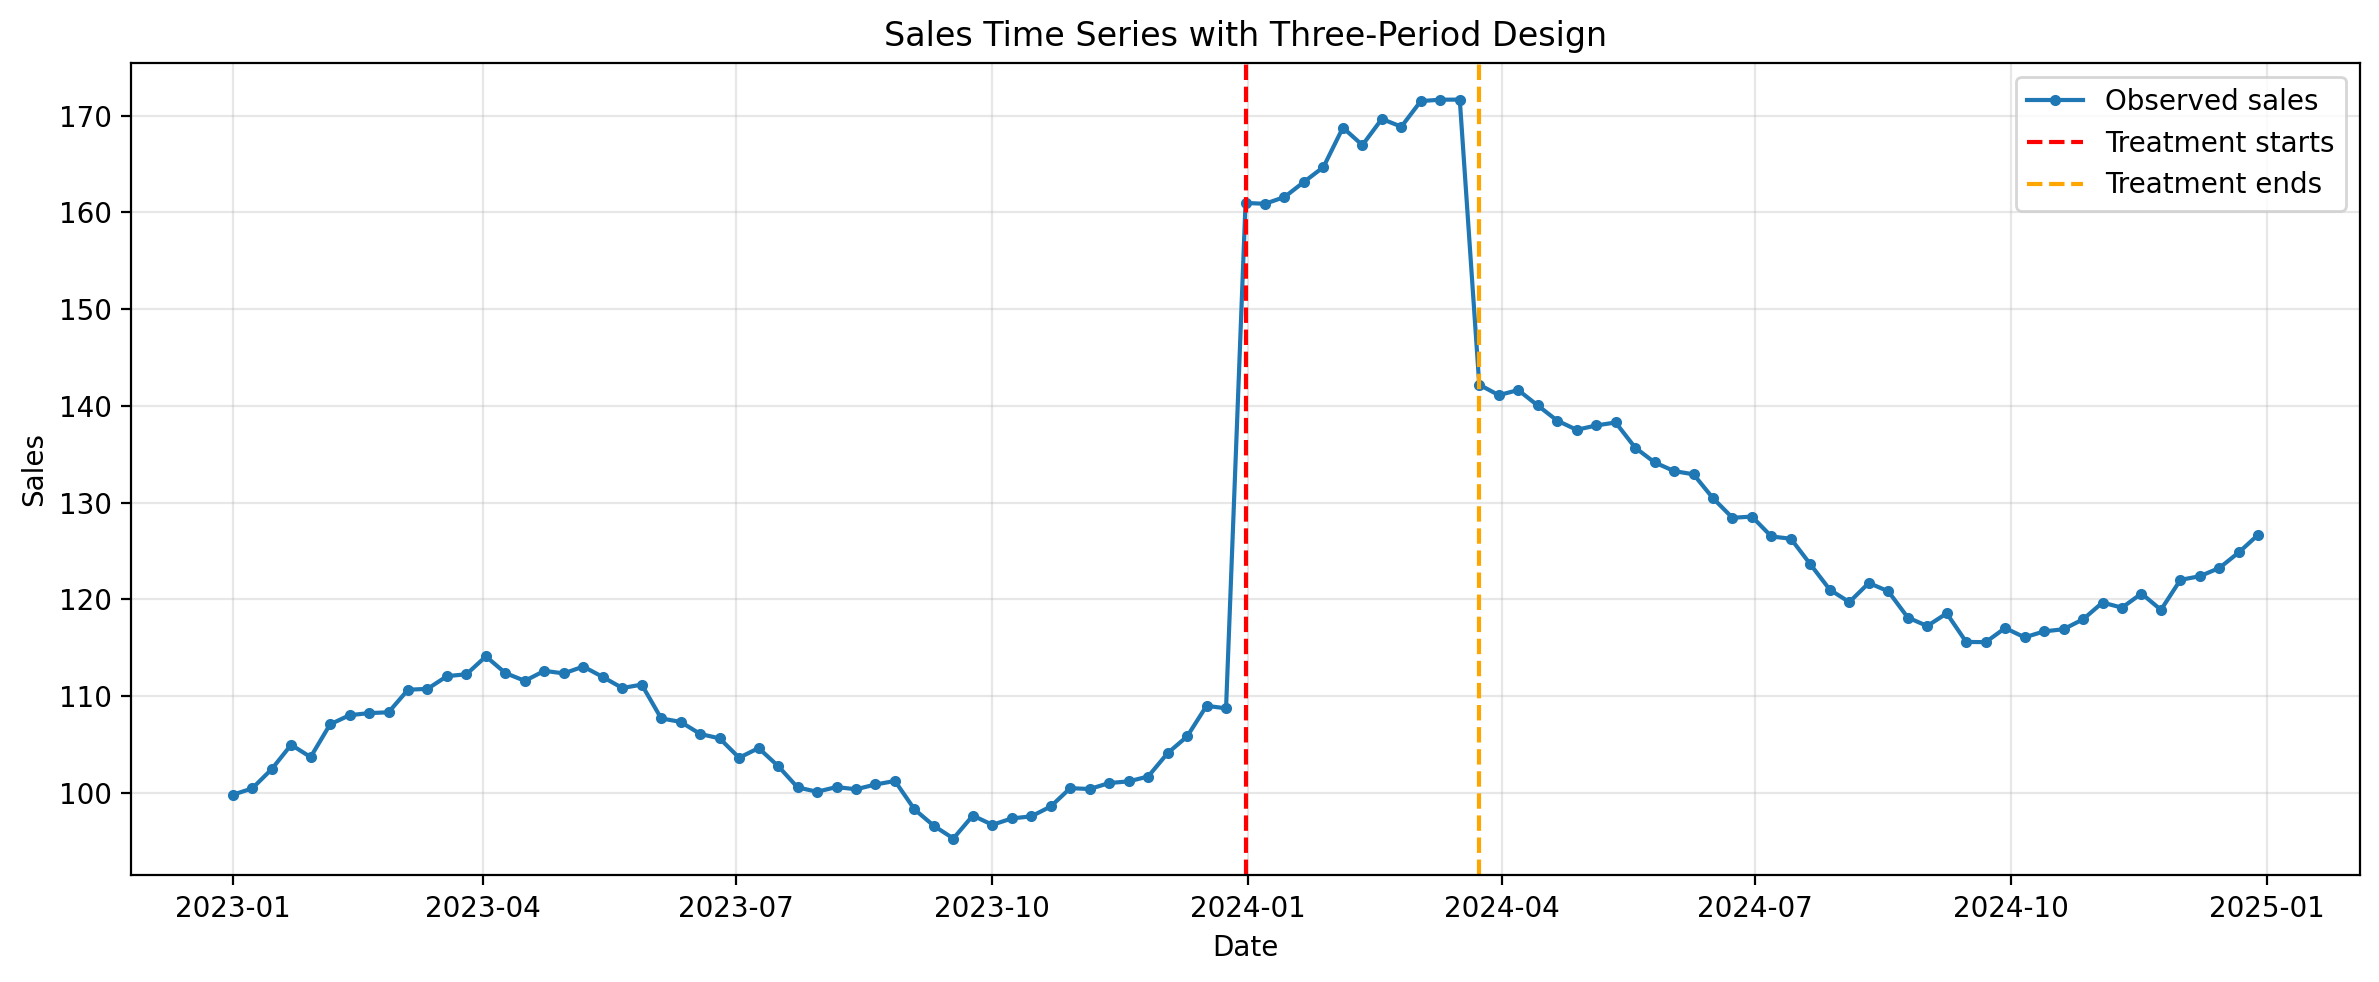

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df["sales"], "o-", markersize=3, label="Observed sales")
ax.axvline(treatment_time, color="red", linestyle="--", label="Treatment starts")
ax.axvline(treatment_end_time, color="orange", linestyle="--", label="Treatment ends")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Sales Time Series with Three-Period Design")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Run three-period analysis

To enable the three-period design, simply provide the `treatment_end_time` parameter:


In [ ]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time=treatment_time,
    treatment_end_time=treatment_end_time,  # NEW: enables three-period design
    formula="sales ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "chains": 4,
            "draws": 4000,
            "random_seed": seed,
            "progressbar": False,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 143 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


### Check new attributes

When `treatment_end_time` is provided, the analysis automatically creates additional attributes for the intervention and post-intervention periods:


In [7]:
print(f"Intervention period data: {len(result.data_intervention)} weeks")
print(f"Post-intervention period data: {len(result.data_post_intervention)} weeks")
print(f"\nIntervention impact shape: {result.intervention_impact.shape}")
print(f"Post-intervention impact shape: {result.post_intervention_impact.shape}")

AttributeError: 'InterruptedTimeSeries' object has no attribute 'data_intervention'

## Period-specific effect summaries

The `effect_summary()` method now supports a `period` parameter to analyze specific periods:


### Intervention period effects


In [ ]:
intervention_summary = result.effect_summary(period="intervention")
print("--- Intervention Period ---")
print(intervention_summary.text)
print("\n")
print(intervention_summary.table)

--- Intervention Period ---
During intervention (2023-12-31 00:00:00 to 2024-03-17 00:00:00), the average effect was 68.77 (95% HDI [43.93, 95.29]), with a posterior probability of an increase of 1.000. The cumulative effect was 825.29 (95% HDI [527.19, 1143.51]); probability of an increase 1.000. Relative to the counterfactual, this equals 74.61% on average (95% HDI [28.92%, 120.32%]).


                  mean      median   hdi_lower    hdi_upper  p_gt_0  \
average      68.773826   69.800379   43.932186    95.292452     1.0   
cumulative  825.285906  837.604549  527.186234  1143.509422     1.0   

            relative_mean  relative_hdi_lower  relative_hdi_upper  
average         74.610705           28.921875          120.324618  
cumulative      74.610705           28.921875          120.324618  


### Post-intervention period effects


In [ ]:
post_summary = result.effect_summary(period="post")
print("--- Post-Intervention Period ---")
print(post_summary.text)
print("\n")
print(post_summary.table)

--- Post-Intervention Period ---
Post-intervention (2024-03-24 00:00:00 to 2024-12-29 00:00:00), the average effect was 30.06 (95% HDI [-4.18, 56.07]), with a posterior probability of an increase of 0.958. The cumulative effect was 1232.28 (95% HDI [-171.28, 2298.72]); probability of an increase 0.958. Relative to the counterfactual, this equals 35.73% on average (95% HDI [-3.54%, 80.28%]).


                   mean       median   hdi_lower    hdi_upper  p_gt_0  \
average       30.055501    30.494517   -4.177490    56.066255   0.958   
cumulative  1232.275532  1250.275189 -171.277101  2298.716449   0.958   

            relative_mean  relative_hdi_lower  relative_hdi_upper  
average         35.733805           -3.544428           80.282499  
cumulative      35.733805           -3.544428           80.282499  


### Compare periods

We can compare the effects across periods to understand persistence:


In [ ]:
# Extract average effects
intervention_avg = intervention_summary.table.loc["average", "mean"]
post_avg = post_summary.table.loc["average", "mean"]

# Calculate persistence ratio
persistence_ratio = (post_avg / intervention_avg) * 100

print(f"Intervention period average effect: {intervention_avg:.2f}")
print(f"Post-intervention period average effect: {post_avg:.2f}")
print(f"\nPersistence ratio: {persistence_ratio:.1f}%")
print(f"(Post-intervention effect is {persistence_ratio:.1f}% of intervention effect)")

Intervention period average effect: 68.31
Post-intervention period average effect: 30.06

Persistence ratio: 44.0%
(Post-intervention effect is 44.0% of intervention effect)


## Visualization


C:\Users\jeanv\AppData\Local\Temp\ipykernel_7356\89665907.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


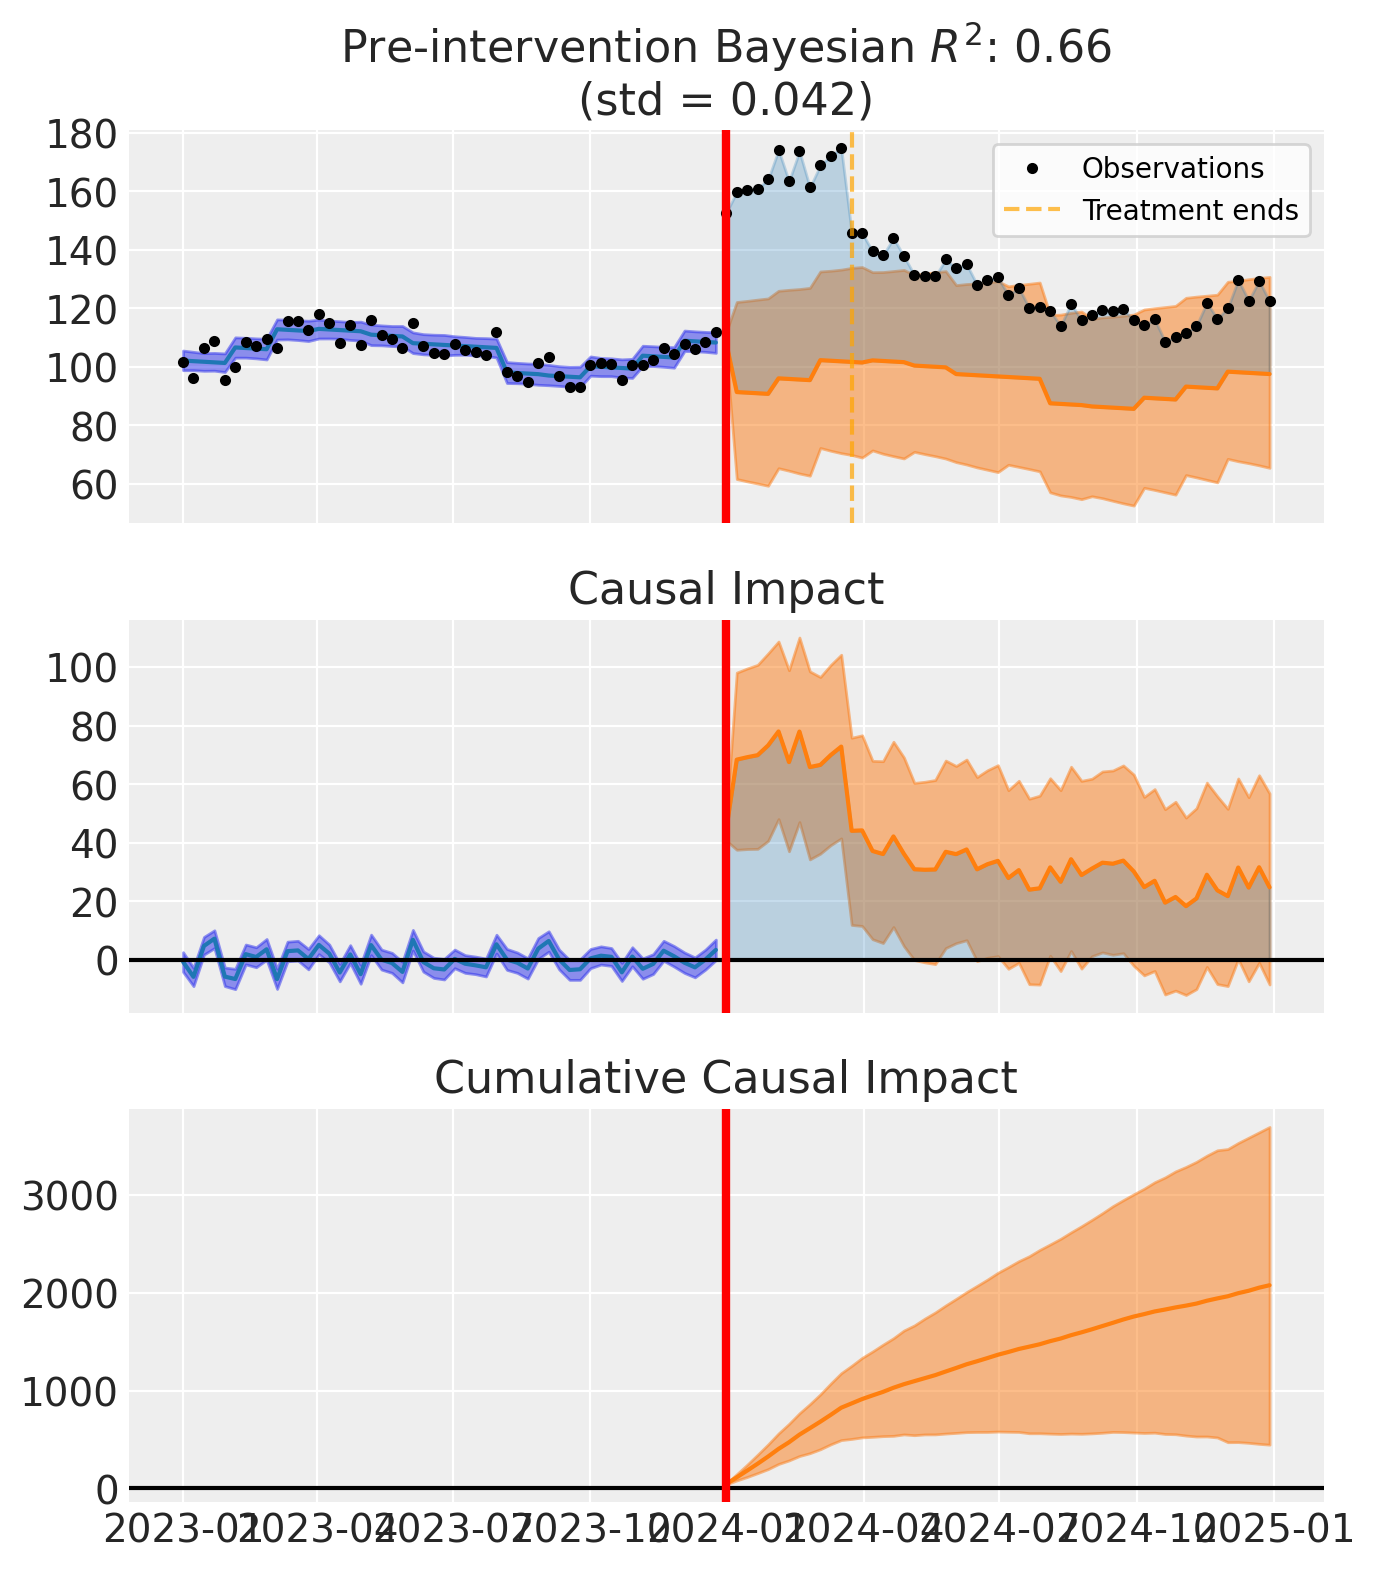

In [8]:
fig, ax = result.plot()
ax[0].axvline(
    treatment_end_time,
    color="orange",
    linestyle="--",
    alpha=0.7,
    label="Treatment ends",
)
ax[0].legend()
plt.tight_layout()
plt.show();

## Analyzing effect persistence

To understand how effects persist after the intervention ends, we can examine the cumulative impacts:


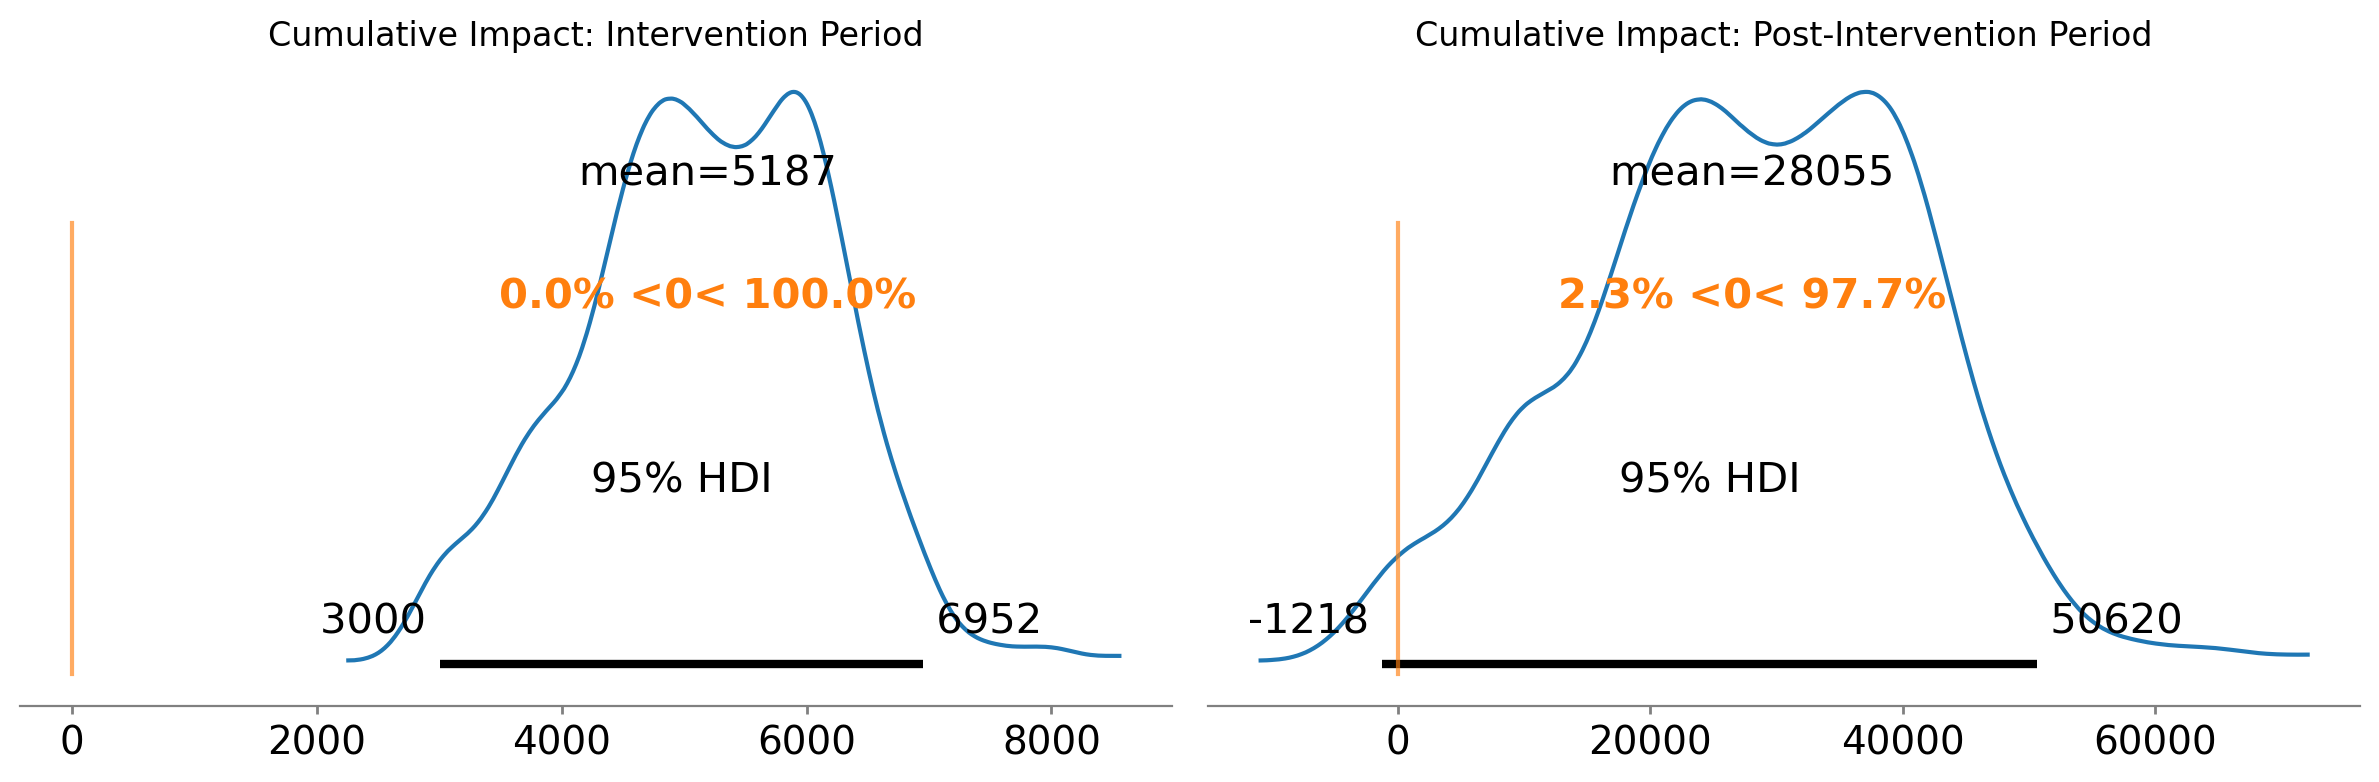

In [ ]:
# Cumulative impacts
intervention_cumulative = result.intervention_impact_cumulative.sum("obs_ind")
post_cumulative = result.post_intervention_impact_cumulative.sum("obs_ind")

# Plot posterior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

az.plot_posterior(
    intervention_cumulative,
    ref_val=0,
    hdi_prob=0.95,
    ax=axes[0],
    point_estimate="mean",
)
axes[0].set_title("Cumulative Impact: Intervention Period")

az.plot_posterior(
    post_cumulative,
    ref_val=0,
    hdi_prob=0.95,
    ax=axes[1],
    point_estimate="mean",
)
axes[1].set_title("Cumulative Impact: Post-Intervention Period")

plt.tight_layout()
plt.show()

## Summary

The three-period design enables comprehensive analysis of temporary interventions:

1. **Immediate effects**: Use `effect_summary(period="intervention")` to analyze effects during the active intervention
2. **Persistence analysis**: Use `effect_summary(period="post")` to measure how effects persist after the intervention ends
3. **Decay patterns**: Compare intervention and post-intervention effects to understand decay dynamics

This design is essential for understanding the full lifecycle of temporary interventions, from immediate impact through long-term persistence.


## References

:::{bibliography}
:filter: docname in docnames
:::
